dataset  : https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018

In [100]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [101]:
df = pd.read_csv('drugsComTrain_raw.csv')
test_df = pd.read_csv('drugsComTest_raw.csv')


In [102]:
df.dropna(inplace=True)

In [103]:
# Convert the date column to a standard format
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [104]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [105]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

df['processed_review'] = df['review'].apply(preprocess_text)
df['processed_condition'] = df['condition'].apply(preprocess_text)


In [106]:
# Combine processed condition and review columns
df['combined_text'] = df['processed_condition'] + " " + df['processed_review']

In [107]:
# TF-IDF Vectorization of combined text
vectorizer = TfidfVectorizer(max_features=500)
X_combined_text = vectorizer.fit_transform(df['combined_text']).toarray()

In [108]:
# Combine TF-IDF features with other numerical features
numerical_features = df[['rating', 'usefulCount']].values
X_combined = np.hstack((X_combined_text, numerical_features))

In [109]:
# Scaling numerical features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

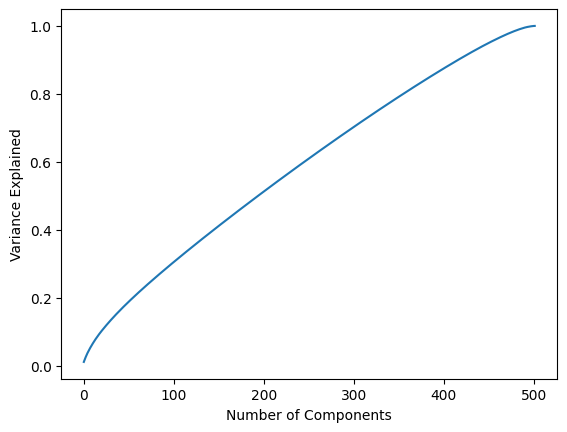

In [110]:
pca = PCA()
X_combined_pca = pca.fit_transform(X_combined_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()


In [111]:
wcss = []  

for i in range(2, 11):    
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_combined_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()



In [ ]:
optimal_clusters = 5  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_combined_pca)


In [ ]:
def recommend_drug(condition, top_n=3):
    # Preprocess the condition input
    processed_condition = preprocess_text(condition)
    
    # Transform the input condition using the same vectorizer
    input_condition_vector = vectorizer.transform([processed_condition]).toarray()
    
    # Combine with zeros for numerical features (dummy input for prediction)
    input_combined = np.hstack((input_condition_vector, np.zeros((1, numerical_features.shape[1]))))
    
    input_combined_scaled = scaler.transform(input_combined)
    
    input_combined_pca = pca.transform(input_combined_scaled)
    
    predicted_cluster = kmeans.predict(input_combined_pca)[0]
    
    recommended_drugs = df[df['Cluster'] == predicted_cluster]['drugName'].value_counts().head(top_n)
    
    return recommended_drugs.index.tolist()


user_condition = "Weight Loss"  
recommended_drugs = recommend_drug(user_condition)
print(f"Recommended drugs for '{user_condition}': {recommended_drugs}")

Recommended drugs for 'Weight Loss': ['Phentermine', 'Bupropion / naltrexone', 'Contrave']
